<a href="https://colab.research.google.com/github/amolpatel18/fintechapp/blob/main/CaseStudy3_CTR_AmolPatel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install catboost

In [12]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import requests
import io
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV
import joblib
from catboost import CatBoostClassifier, Pool


## 1. Data Read

In [41]:
# Map hour to time-of-day
def map_time_of_day(hour):
    if 0 <= hour < 6:
        return 0 #night
    elif 6 <= hour < 12:
        return 1 #morning
    elif 12 <= hour < 18:
        return 2 #afternoon
    else:
        return 3 #evening


def col_encoding(df_train):
  #for col in df_train:
    #print(f"{col} : {df_train[col].nunique()} \t {df_train[col].unique()}")
  # Label encoding for categorical columns
  label_cols = ['product', 'campaign_id', 'webpage_id', 'user_group_id']
  for col in label_cols:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])



  # Cyclical encoding for time features
  import numpy as np
  #optimization
  #df_train['DoW_sin'] = np.sin(2 * np.pi * df_train['DoW'] / 7)
  #df_train['DoW_cos'] = np.cos(2 * np.pi * df_train['DoW'] / 7)
  df_train['HoD_sin'] = np.sin(2 * np.pi * df_train['HoD'] / 24)
  df_train['HoD_cos'] = np.cos(2 * np.pi * df_train['HoD'] / 24)

  #optimization
  #df_train.drop(columns='HoD',inplace=True)
  df_train.drop(columns='ToD',inplace=True)
  df_train.drop(columns='DoW',inplace=True)
  df_train.drop(columns='DoM',inplace=True)


  #Feature interaction
  df_train['age_gender_product'] = df_train['age_level'] * df_train['gender'] * df_train['product']

  #Feature engineering
  df_train['campaign_webpage_ctr'] = df_train.groupby(['campaign_id','webpage_id'])['is_click'].transform('mean')
  df_train['age_product_city_ctr'] = df_train.groupby(['age_level','product', 'city_development_index'])['is_click'].transform('mean')
  df_train['campaign_gender_age_city_ctr'] = df_train.groupby(['campaign_id','gender','age_level','city_development_index'])['is_click'].transform('mean')
  df_train['userid_ctr'] = df_train.groupby(['user_id'])['is_click'].transform('mean')
  df_train['product_ctr'] = df_train.groupby(['product'])['is_click'].transform('mean')
  df_train['user_group_id_ctr'] = df_train.groupby(['user_group_id'])['is_click'].transform('mean')
  df_train['campaign_ctr'] = df_train.groupby(['campaign_id'])['is_click'].transform('mean')
  df_train['HoD_ctr'] = df_train.groupby(['HoD'])['is_click'].transform('mean')
  df_train['is_weekend_ctr'] = df_train.groupby(['is_weekend'])['is_click'].transform('mean')

  '''
  print(f"Column post encoding\n")
  for col in df_train:
    print(f"{col} : {df_train[col].nunique()} \t {df_train[col].unique()}")
  '''
  return(df_train)

def data_creation(df_train):
  df_train['DateTime'] = pd.to_datetime(df_train['DateTime'])
  df_train['DoM'] = df_train['DateTime'].dt.day
  df_train['month'] = df_train['DateTime'].dt.month
  df_train['HoD'] = df_train['DateTime'].dt.hour
  df_train['DoW'] = df_train['DateTime'].dt.weekday
  df_train['ToD'] = df_train['DateTime'].dt.hour
  # is_weekend column: 1 if Saturday(5) or Sunday(6), else 0
  df_train['is_weekend'] = df_train['DoW'].apply(lambda x: 1 if x >= 5 else 0)

  #Drop duplicate rows and two columns
  df_train.drop_duplicates(inplace=True)
  df_train.drop(columns=['session_id','DateTime'],inplace=True)
  df_train.drop(columns=['product_category_2'],inplace=True)

  #print("Dropping user_id")
  #df_train.drop(columns='user_id',inplace=True)

  #optimization
  #Reduce columns further
  #only One month data so drop Month
  df_train.drop(columns='month',inplace=True)

  # Get list of all columns
  columns = ['user_group_id','gender','age_level','user_depth','city_development_index']

  # Traverse through columns and fill NaN with most commonly used value
  for col in columns:
      most_common_value = df_train[col].mode()[0]
      count = df_train[df_train[col] == most_common_value].shape[0]
      #print(f"Before \t: {col}: most_common_value : {most_common_value} count : {count} ")
      #df_train[col].fillna(most_common_value, inplace=True)
      df_train.fillna({col : most_common_value}, inplace=True)
      count = df_train[df_train[col] == most_common_value].shape[0]
      #print(f"After \t{col}: most_common_value : {most_common_value} count : {count} ")

  df_train['gender'] = df_train['gender'].map({'Female':0,'Male':1})
  df_train['product'] = df_train['product'].apply(lambda x: ord(x.upper()) - ord('A') + 1)
  return df_train


In [14]:
!gdown 1xlExuwCOS8fVB4Ol3cWM1BG_gsEDTvSE

Downloading...
From: https://drive.google.com/uc?id=1xlExuwCOS8fVB4Ol3cWM1BG_gsEDTvSE
To: /content/Ad_click_prediction_train (1).csv
100% 34.3M/34.3M [00:00<00:00, 57.5MB/s]


In [40]:
def read_data():
  #!gdown 1xlExuwCOS8fVB4Ol3cWM1BG_gsEDTvSE
  file_path1 = r'/content/Ad_click_prediction_train (1).csv'
  #file_path1 = '/home/intel/amolp/ad_click_prediction_train.csv'
  df_train = pd.read_csv(file_path1)
  #print(df_train.info())
  return df_train

In [72]:
def get_fresh_encoded_data():
  df_train = read_data()
  df_train = data_creation(df_train)
  df_train = col_encoding(df_train)
  return df_train

In [74]:
df_temp = get_fresh_encoded_data()
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463291 entries, 0 to 463290
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   user_id                       463291 non-null  int64  
 1   product                       463291 non-null  int64  
 2   campaign_id                   463291 non-null  int64  
 3   webpage_id                    463291 non-null  int64  
 4   product_category_1            463291 non-null  int64  
 5   user_group_id                 463291 non-null  int64  
 6   gender                        463291 non-null  int64  
 7   age_level                     463291 non-null  float64
 8   user_depth                    463291 non-null  float64
 9   city_development_index        463291 non-null  float64
 10  var_1                         463291 non-null  int64  
 11  is_click                      463291 non-null  int64  
 12  HoD                           463291 non-nul

In [16]:
import sys

df_train = read_data()
df_train = data_creation(df_train)
df_train = col_encoding(df_train)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463291 entries, 0 to 463290
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   session_id              463291 non-null  int64  
 1   DateTime                463291 non-null  object 
 2   user_id                 463291 non-null  int64  
 3   product                 463291 non-null  object 
 4   campaign_id             463291 non-null  int64  
 5   webpage_id              463291 non-null  int64  
 6   product_category_1      463291 non-null  int64  
 7   product_category_2      97437 non-null   float64
 8   user_group_id           445048 non-null  float64
 9   gender                  445048 non-null  object 
 10  age_level               445048 non-null  float64
 11  user_depth              445048 non-null  float64
 12  city_development_index  338162 non-null  float64
 13  var_1                   463291 non-null  int64  
 14  is_click            

## Phase 2: Feature Engineering

## Phase 3: Data Preprocessing
Step 1: Handle Missing Values
Strategy:
# Numerical columns: Fill with median (robust to outliers)
# Categorical columns: Fill with mode (most frequent value)
Step 2: Encode Categorical Variables
Approach: Label Encoding
Columns to Encode:
● product
● campaign_id
● webpage_id
● product_category_1, product_category_2
● gender
● user_group_id
● var_1
● All interaction features (user_product_interaction, etc.)
Step 3: Feature Selection
Columns to Drop:
drop_cols = ['DateTime', 'session_id', 'user_id']
Why Drop These?
● DateTime: Already extracted features from it
● session_id: Too granular, no predictive value
● user_id: Causes overfitting (too many unique values)

## Phase 1: Data Exploration & Understanding

In [17]:
def heat_map(df,target_col):
  #create figure for the heatmap
  plt.figure(figsize=(12,8))

  #calculat correlation b/w the target_col and rest of the columns, sort by correlation
  corr = df.corr()[target_col].to_frame().sort_values(by=target_col,ascending=False)

  #Generate heatmap with annotations using the "Blues" colourmap
  sns.heatmap(corr,annot=True,cmap="Blues")

  #set the title for the heatmap
  plt.title(f"{target_col} correlation heatmap")

  plt.show()

In [18]:
df_train = read_data()
df_train = data_creation(df_train)

#print(f"commenting col_encoding as catboost does NOT require it\n")
df_train = col_encoding(df_train)


#sample_df = df_train.sample(frac=1,random_state=99)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463291 entries, 0 to 463290
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   session_id              463291 non-null  int64  
 1   DateTime                463291 non-null  object 
 2   user_id                 463291 non-null  int64  
 3   product                 463291 non-null  object 
 4   campaign_id             463291 non-null  int64  
 5   webpage_id              463291 non-null  int64  
 6   product_category_1      463291 non-null  int64  
 7   product_category_2      97437 non-null   float64
 8   user_group_id           445048 non-null  float64
 9   gender                  445048 non-null  object 
 10  age_level               445048 non-null  float64
 11  user_depth              445048 non-null  float64
 12  city_development_index  338162 non-null  float64
 13  var_1                   463291 non-null  int64  
 14  is_click            

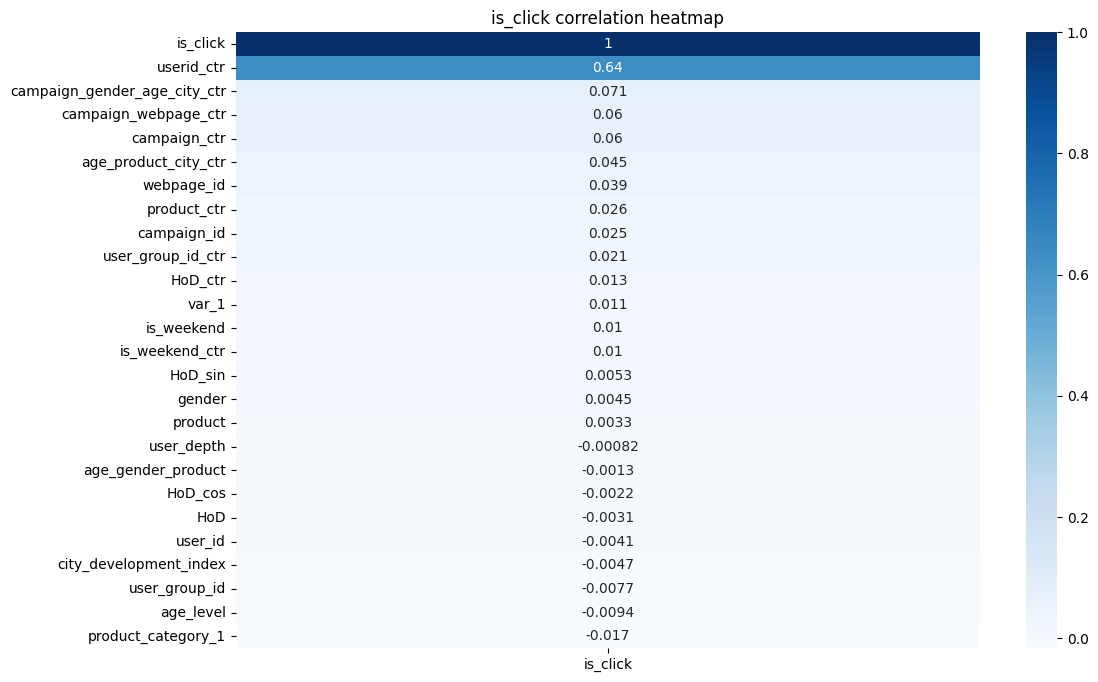

In [19]:
heat_map(df_train,'is_click')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463291 entries, 0 to 463290
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   session_id              463291 non-null  int64  
 1   DateTime                463291 non-null  object 
 2   user_id                 463291 non-null  int64  
 3   product                 463291 non-null  object 
 4   campaign_id             463291 non-null  int64  
 5   webpage_id              463291 non-null  int64  
 6   product_category_1      463291 non-null  int64  
 7   product_category_2      97437 non-null   float64
 8   user_group_id           445048 non-null  float64
 9   gender                  445048 non-null  object 
 10  age_level               445048 non-null  float64
 11  user_depth              445048 non-null  float64
 12  city_development_index  338162 non-null  float64
 13  var_1                   463291 non-null  int64  
 14  is_click            

/tmp/ipython-input-999958569.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot( x=usage_count['usage_group'], y=usage_count['count'], palette="viridis")


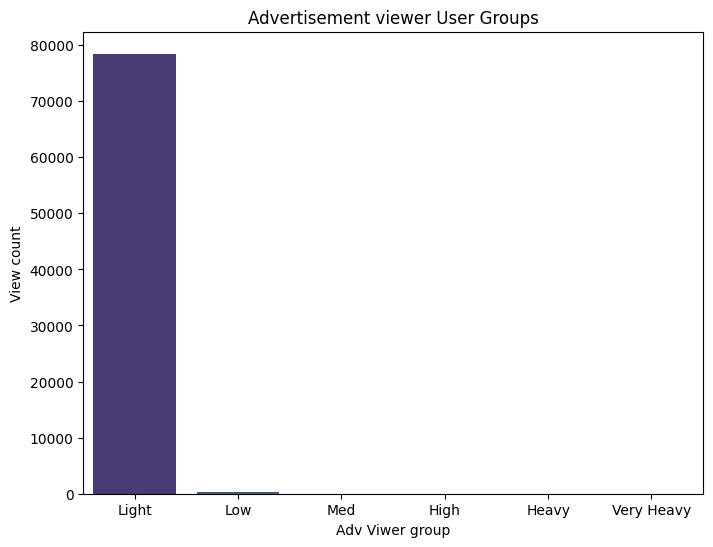

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#- **user_sessions:** Number of unique sessions per user
df_train = read_data()
#df_train = data_creation(df_train)


gr_df_user_session = df_train.groupby('user_id')['session_id'].nunique().reset_index()
gr_df_user_session.rename(columns={'session_id': 'unique_sessions'}, inplace=True)
gr_df_user_session.sort_values(by='unique_sessions',ascending=False,inplace=True)
print(gr_df_user_session)
print(gr_df_user_session['unique_sessions'].max())
print(gr_df_user_session['unique_sessions'].mean())

bins = [1,51,101,151,201,251,300]
labels = ['Light','Low','Med','High','Heavy','Very Heavy']
gr_df_user_session['usage_group'] = pd.cut(gr_df_user_session['unique_sessions'], bins=bins,labels=labels)

usage_count = gr_df_user_session['usage_group'].value_counts().reset_index()
usage_count.columns= ['usage_group','count']
print(usage_count)


# Assume importances_sorted is already created
# Example:
# importances_sorted = importances.sort_values(ascending=False)

# Plot the bar chart
plt.figure(figsize=(8, 6))
sns.barplot( x=usage_count['usage_group'], y=usage_count['count'], palette="viridis")

# Add title and labels
plt.title("Advertisement viewer User Groups")
plt.xlabel("Adv Viwer group")
plt.ylabel("View count")
plt.show()


In [26]:
#- **user_product_interaction:** `user_group_id + product`

gr_df_user_session = df_train.groupby(['user_group_id','product'])['session_id'].nunique().reset_index()
#gr_df_user_session.rename(columns={'User','Product','unique_sessions'}, inplace=True)
gr_df_user_session.sort_values(by='session_id',ascending=False,inplace=True)
gr_df_user_session.columns = ['user_group_id','product','session_count']
gr_df_user_session

,user_group_id,product,session_count
32,3.0,C,51828
22,2.0,C,50573
37,3.0,H,35643
27,2.0,H,28587
28,2.0,I,21657
...,...,...,...
0,0.0,A,11
5,0.0,F,9
3,0.0,D,9
6,0.0,G,6


In [27]:
#- **user_product_interaction:** `user_id + product`

gr_df_user_session = df_train.groupby(['user_id','product'])['session_id'].nunique().reset_index()
#gr_df_user_session.rename(columns={'User','Product','unique_sessions'}, inplace=True)
gr_df_user_session.sort_values(by='session_id',ascending=False,inplace=True)
gr_df_user_session.columns = ['user_id','product','session_count']
gr_df_user_session

,user_id,product,session_count
151808,658554,H,119
70102,297960,C,100
203804,929999,H,93
134598,580576,H,82
89508,382796,H,79
...,...,...,...
245830,1141687,C,1
245818,1141629,I,1
245820,1141645,A,1
245821,1141645,C,1


In [29]:
gr_df_camp_web = df_train[df_train['is_click'] == 1].copy(deep=True)
gr_df_camp_web = gr_df_camp_web.groupby(['campaign_id','webpage_id'])['is_click'].count().reset_index().sort_values(by='is_click',ascending=False)
print(gr_df_camp_web)

   campaign_id  webpage_id  is_click
8       405490       60305      8763
4       359520       13787      6340
1        98970        6970      2694
5       360936       13787      2346
7       404347       53587      2235
3       118601       28529      1896
6       396664       51181      1809
0        82320        1734      1776
2       105960       11085      1762
9       414149       45962      1710


In [32]:
#df_train = read_data()
gr_df_camp  = df_train[df_train['is_click'] == 1].copy(deep=True)
gr_df_camp_gr = gr_df_camp.groupby(['campaign_id'])['is_click'].count().reset_index().sort_values(by='is_click',ascending=False)
print(gr_df_camp_gr)

   campaign_id  is_click
8       405490      8763
4       359520      6340
1        98970      2694
5       360936      2346
7       404347      2235
3       118601      1896
6       396664      1809
0        82320      1776
2       105960      1762
9       414149      1710


####Conclusion : CampaingID 405490 and 359520 are the most successful campaigns with the highest number of clicks

In [33]:
gr_df_gender_age_level = df_train[df_train['is_click'] == 1].copy(deep=True)
gr_df_gender_age_level = gr_df_gender_age_level.groupby(['age_level','gender'])['is_click'].count().reset_index().sort_values(by='is_click',ascending=False)
gr_df_gender_age_level.columns = ['age_level','gender','click_count']
print(gr_df_gender_age_level)

    age_level  gender  click_count
5         2.0    Male         9780
7         3.0    Male         9074
3         1.0    Male         3152
9         4.0    Male         2971
11        5.0    Male         1608
6         3.0  Female         1286
8         4.0  Female          779
10        5.0  Female          678
4         2.0  Female          397
13        6.0    Male          135
2         1.0  Female           92
12        6.0  Female           92
1         0.0    Male           12
0         0.0  Female            1


2. Interaction Features
Why: Combinations of features often reveal hidden patterns
Features to Create:

user_product_interaction: user_id + product
Ans : Users tend to click at the same product ad when they are actually planning to buy and exploring the options.

campaign_webpage: campaign_id + webpage_id Ans: Top 2 campain+Webpage_ids combinations had 100-150% more clicks then rest of the lot



```
 campaign_id  webpage_id  is_click
8       405490       60305      8763
4       359520       13787      6340
1        98970        6970      2694
5       360936       13787      2346
7       404347       53587      2235
3       118601       28529      1896
6       396664       51181      1809
0        82320        1734      1776
2       105960       11085      1762
9       414149       45962      1710
```

gender_age: gender + age_level** Ans Males of all the age_level has got significantly more clicks than the feamales



```
age_level  gender  click_count
5         2.0     1.0         9780
7         3.0     1.0         9074
3         1.0     1.0         3152
9         4.0     1.0         2971
11        5.0     1.0         1608
6         3.0     0.0         1286
8         4.0     0.0          779
10        5.0     0.0          678
4         2.0     0.0          397
13        6.0     1.0          135
2         1.0     0.0           92
12        6.0     0.0           92
1         0.0     1.0           12
0         0.0     0.0            1```





### **3. Aggregated Features**

**Why:** Historical performance is a strong predictor of future behavior.

---

#### **User-Level Aggregations**
- **user_total_views:** How many ads has this user seen?
**Ans**:
min 1 and max 255
- **user_total_clicks:** How many times has this user clicked?
**Ans**:
- **user_ctr:** User's personal click-through rate
- **user_sessions:** Number of unique sessions per user


```
max_ctr : 100.0
min_ctr : 0.7751937984496124
mean_ctr: 46.91466952256051
index	user_id	view_count	click_count	CTR%
238	 252158	       51	      15	     29.411765
15	 357044	       113	    13	     11.504425
126	 222506	        63	    12	     19.047619
57	 40010	        81    	12	     14.814815
183	691846	        55    	11      	20.000000
...	...	...	...	...	...
25373	1141657	      1	      1	      100.000000
```

#### **Product-Level Aggregations**
- **product_views:** Total times this product was shown
- **product_ctr:** This product's historical click rate


```
max_ctr : 9.269952567539699
min_ctr : 4.620777565328234
mean_ctr: 6.485455051725803
   index  product  view_count  click_count      CTR%
7      7       10        9698          899  9.269953
3      3        4       41064         2949  7.181473
1      1        8      109574         7654  6.985234
0      0        3      163501        11306  6.914942
5      5        5       21452         1474  6.871154
2      2        9       63711         4079  6.402348
6      6        1       15391          953  6.191930
4      4        2       22479         1238  5.507362
9      9        6        7007          344  4.909376
8      8        7        9414          435  4.620778
```


---

#### **Campaign-Level Aggregations**
- **campaign_views:** Total impressions for this campaign
- **campaign_ctr:** Campaign's historical performance

```
max_ctr : 9.130693007408334
min_ctr : 4.5212765957446805
mean_ctr: 6.659396870137525
   index  campaign_id  view_count  click_count      CTR%
1      1       405490       95973         8763  9.130693
6      6       404347       28826         2235  7.753417
4      4        98970       35065         2694  7.682875
9      9       396664       24909         1809  7.262435
8      8       105960       25781         1762  6.834491
7      7        82320       27849         1776  6.377249
0      0       359520      108155         6340  5.861957
5      5       414149       29314         1710  5.833390
3      3       118601       35531         1896  5.336185
2      2       360936       51888         2346  4.521277
```



In [35]:
#User-Level Aggregations
gr_user_df1 = df_train.groupby('user_id')['is_click'].count().reset_index().sort_values(by='is_click',ascending=False)
gr_user_df1.columns = ['user_id','view_count']
gr_user_df1

,user_id,view_count
92290,658554,255
42549,297960,225
129997,983136,187
59874,422201,157
124461,929999,143
...,...,...
78746,560482,1
78745,560474,1
78744,560470,1
78743,560467,1


In [36]:
gr_user_df = df_train[df_train['is_click'] == 1].groupby('user_id')['is_click'].count().reset_index().sort_values(by='is_click',ascending=False)
gr_user_df.columns = ['user_id','click_count']
gr_user_df

,user_id,click_count
6392,252158,15
8726,357044,13
1026,40010,12
5577,222506,12
16446,691846,11
...,...,...
9232,377920,1
9231,377869,1
9230,377746,1
9229,377711,1


In [37]:
gr_user_df_ctr = pd.merge(gr_user_df1,gr_user_df,on='user_id').reset_index().sort_values(by='click_count',ascending=False)
gr_user_df_ctr['CTR%'] = 100 * gr_user_df_ctr['click_count']/gr_user_df_ctr['view_count']


print(f"max_ctr : {gr_user_df_ctr['CTR%'].max()}")
print(f"min_ctr : {gr_user_df_ctr['CTR%'].min()}")
print(f"mean_ctr: {gr_user_df_ctr['CTR%'].mean()}")
gr_user_df_ctr

max_ctr : 100.0
min_ctr : 0.7751937984496124
mean_ctr: 46.91466952256051


,index,user_id,view_count,click_count,CTR%
238,238,252158,51,15,29.411765
15,15,357044,113,13,11.504425
126,126,222506,63,12,19.047619
57,57,40010,81,12,14.814815
183,183,691846,55,11,20.000000
...,...,...,...,...,...
25373,25373,1141657,1,1,100.000000
25372,25372,414,1,1,100.000000
25371,25371,1141220,1,1,100.000000
25370,25370,532,1,1,100.000000


In [38]:
'''
Product-Level Aggregations: - product_views: Total times this product was shown - product_ctr: This product's historical click rate
'''
#User-Level Aggregations
gr_prod_df1 = df_train.groupby('product')['is_click'].count().reset_index().sort_values(by='is_click',ascending=False)
gr_prod_df1.columns = ['product','view_count']


gr_prod_df = df_train[df_train['is_click'] == 1].groupby('product')['is_click'].count().reset_index().sort_values(by='is_click',ascending=False)
gr_prod_df.columns = ['product','click_count']
#gr_prod_df

gr_prod_df_ctr = pd.merge(gr_prod_df1,gr_prod_df,on='product').reset_index().sort_values(by='click_count',ascending=False)
gr_prod_df_ctr['CTR%'] = 100 * gr_prod_df_ctr['click_count']/gr_prod_df_ctr['view_count']


print(f"max_ctr : {gr_prod_df_ctr['CTR%'].max()}")
print(f"min_ctr : {gr_prod_df_ctr['CTR%'].min()}")
print(f"mean_ctr: {gr_prod_df_ctr['CTR%'].mean()}")
print(gr_prod_df_ctr.sort_values(by='CTR%',ascending=False))



max_ctr : 9.269952567539699
min_ctr : 4.620777565328234
mean_ctr: 6.485455051725803
   index product  view_count  click_count      CTR%
7      7       J        9698          899  9.269953
3      3       D       41064         2949  7.181473
1      1       H      109574         7654  6.985234
0      0       C      163501        11306  6.914942
5      5       E       21452         1474  6.871154
2      2       I       63711         4079  6.402348
6      6       A       15391          953  6.191930
4      4       B       22479         1238  5.507362
9      9       F        7007          344  4.909376
8      8       G        9414          435  4.620778


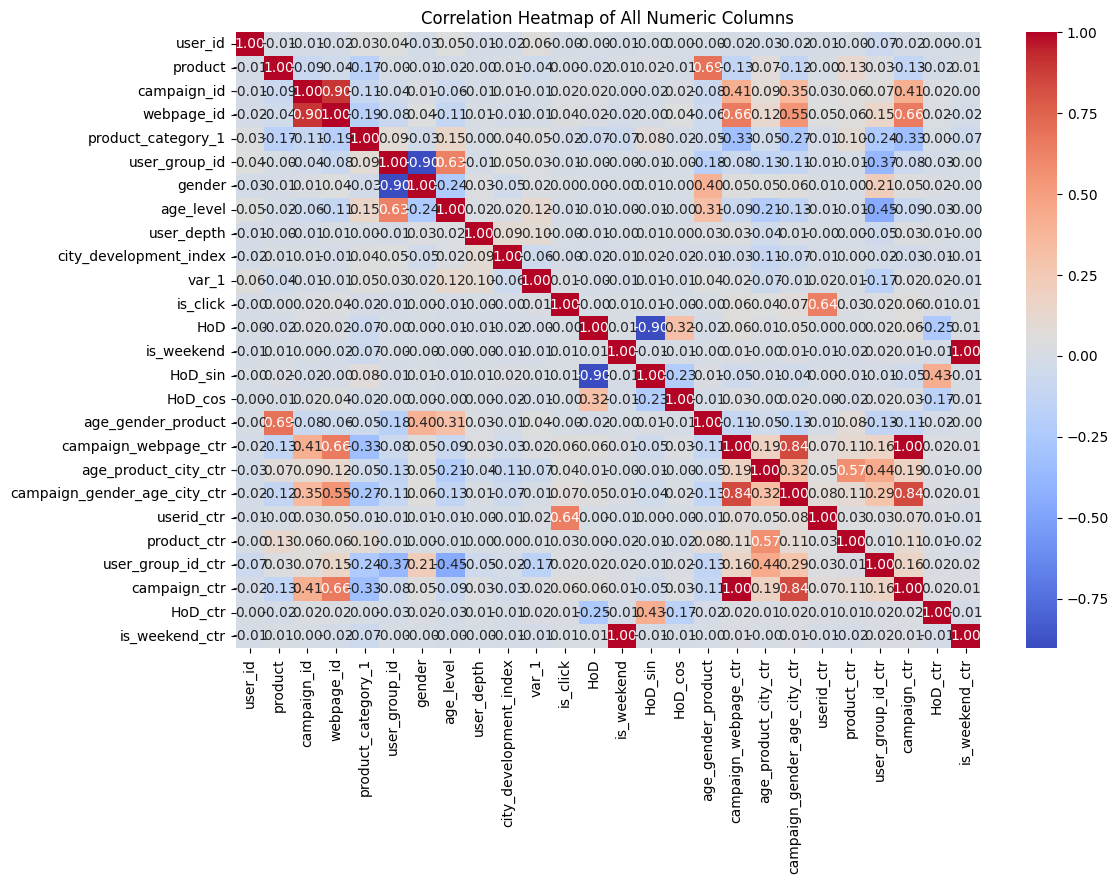

In [42]:
df_train = read_data()
df_train = data_creation(df_train)
df_train = col_encoding(df_train)
corr_matrix = df_train.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of All Numeric Columns')
plt.show()


Key Questions to Answer:
1. Target Distribution
  ○ What percentage of ads get clicked?
  ○ Is the dataset severely imbalanced?
  ○ Do you need resampling techniques?
2. Temporal Patterns
  ○ Which hours have highest click rates?
  ○ Are weekends different from weekdays?
  ○ Do certain months perform better?
3. User Behavior
  ○ Do certain age groups click more?
  ○ Is there a gender difference in click rates?
  ○ How does user group affect clicking?
4. Campaign Performance
  ○ Which campaigns have highest CTR?
  ○ Which products get more clicks?
  ○ Do certain webpages convert better?

In [43]:
#Visualise categorical data
def visulaise_cat(df,cat_cols,target_col):
  #number of rows and cols for the subplots
  num_cols = len(cat_cols)
  num_rows = (int)(len(cat_cols)/3) #3 plots in one row
  fig, axes= plt.subplots(num_rows,num_cols,figsize=(10,6))
  axes = axes.flatten() #Flatten 2D array of the axes for the easy iteration
  for i, col in enumerate(cat_cols):
    ax = axes[i]
    sns.countplot(data=df,x=col,ax=ax,palette="Blues", hue=target_col)
    ax.set_title(f"Bar plot of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    break
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [61]:
columns = df_train.columns
#ret = visulaise_cat(df_train, columns,'is_click')

In [45]:
status_percent = df_train['is_click'].value_counts(normalize=True) * 100
print(status_percent)

is_click
0    93.237296
1     6.762704
Name: proportion, dtype: float64


####Conclusion CTR Rate 6.76%, these many % of ads are getting clicked

In [59]:
import sys
# List of columns to visualize (excluding is_click)
df_train = read_data()
df_train = data_creation(df_train)
columns = df_train.columns.tolist()
columns.remove('is_click')


cols_to_visualize = [col for col in columns]


for i, col in enumerate(cols_to_visualize, 1):
    # Aggregate sum of is_click for each unique value in the column
    df_train_click = df_train[df_train['is_click'] == 1]
    agg_data = df_train_click.groupby(col)['is_click'].sum().sort_values(ascending=False).reset_index()
    print(f"{col}\n : {agg_data}")


user_id
 :        user_id  is_click
0       252158        15
1       357044        13
2        40010        12
3       222506        12
4       691846        11
...        ...       ...
25372   377920         1
25373   377869         1
25374   377746         1
25375   377711         1
25376   378346         1

[25377 rows x 2 columns]
product
 :    product  is_click
0        3     11306
1        8      7654
2        9      4079
3        4      2949
4        5      1474
5        2      1238
6        1       953
7       10       899
8        7       435
9        6       344
campaign_id
 :    campaign_id  is_click
0       405490      8763
1       359520      6340
2        98970      2694
3       360936      2346
4       404347      2235
5       118601      1896
6       396664      1809
7        82320      1776
8       105960      1762
9       414149      1710
webpage_id
 :    webpage_id  is_click
0       60305      8763
1       13787      8686
2        6970      2694
3       53587      22

###Conclusion:
#Target Distribution
○ What percentage of ads get clicked? 6.76%
○ Is the dataset severely imbalanced?  Yes
○ Do you need resampling techniques?  Yes




# Temporal Patterns
○ Which hours have highest click rates?  Morning hours (6 am to 12 noon)
○ Are weekends different from weekdays?  Nope it's looking the same
○ Do certain months perform better?  Only one month (july) data available, so this can NOT be ascertained.


User Behavior
○ Do certain age groups click more? Yes, Age level 3 has highest clicks closely followed by age level 2.0
○ Is there a gender difference in click rates? Yes, Male user click ratio is almost 9 times more than the females
○ How does user group affect clicking? User_groupid 3 has got the highest clicks closely followed by the groupid 2. This is closely matching the Age levels numbers.


4. Campaign Performance
○ Which campaigns have highest CTR? 405490
○ Which products get more clicks?  3
○ Do certain webpages convert better? WebpageIDs : 60305 and 13787 has got significantly more clicks then rest of the webpageIDs.


```
    DoM  is_click
0    7      4401
1    6      4811
2    5      4903
3    4      5327
4    2      5791
5    3      6098**
```

2. Interaction Features
Why: Combinations of features often reveal hidden patterns
Features to Create:

user_product_interaction: user_id + product
campaign_webpage: campaign_id + webpage_id
gender_age: gender + age_level
Rationale:

Specific user-product combinations might have high affinity
Campaign effectiveness varies by placement
Demographics combinations reveal micro-segments
3. Aggregated Features
Why: Historical performance is a strong predictor

User-Level Aggregations:

user_total_views: How many ads has this user seen?
user_total_clicks: How many times has this user clicked?
user_ctr: User's personal click-through rate
user_sessions: Number of unique sessions per user Ans:

```
      user_id  unique_sessions
92290    658554              255
42549    297960              225
129997   983136              187
59874    422201              157
124461   929999              143
...         ...              ...
78746    560482                1
78745    560474                1
78744    560470                1
78743    560467                1
150341  1141713                1

[150347 rows x 2 columns]
255
3.0814781804758327
  usage_group  count
0       Light  78461
1         Low    267
2         Med     23
3        High      2
4       Heavy      1
5  Very Heavy      1
```

### Conclusion : **Scaling is NOT required as all the columns are categorical columns**

## Phase 4 Phase Model Parameter Tuning and Model building

In [63]:
from xgboost import XGBClassifier
models = {  # Dictionary of models to be evaluated

        #"Logistic Regression": LogisticRegression(),
        "Gradient Boosting": GradientBoostingClassifier(),
        "AdaBoost": AdaBoostClassifier(),
        "Gaussian Naive Bayes": GaussianNB(),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(),
        "Support Vector Machine": SVC(),
        "XGBClassifier":XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4,subsample=0.8,colsample_bytree=0.8,eval_metric='logloss')
    }

In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(y_true, y_pred):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate precision
    precision = precision_score(y_true, y_pred)

    # Calculate recall
    recall = recall_score(y_true, y_pred)

    # Calculate F1 score
    f1 = f1_score(y_true, y_pred)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, cm

In [65]:
def run_model(df,model,name):
  #X,y
  X = df.drop('is_click',axis=1)
  y = df['is_click']

  #split
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=99,stratify=y)

  #optimization don't apply SMOTE

  # Apply SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes in the training set
  #smote = SMOTE(random_state=42)
  #X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
  X_train_resampled = X_train
  y_train_resampled = y_train


  # Fit the model on the resampled training data
  model.fit(X_train_resampled, y_train_resampled)

  # Make predictions on the test set
  predictions = model.predict(X_test)

  # Return the model's predictions and the actual labels (y_test)
  return predictions, y_test

In [75]:
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier

def models_eva(data):
    results = []  # Initialize a list to store results
    cm_data = []  # Initialize a list to store confusion matrix data
    roc_data = []  # Initialize a list to store ROC curve data
    #models = {  # Dictionary of models to be evaluated

     #     "XGBClassifier":XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4,subsample=0.8,colsample_bytree=0.8,eval_metric='logloss')
    #}

    # Iterate through the models
    for name, model in models.items():
    #name = "XGBClassifier"
    #for lr in np.arange(0.1,2.0,0.2):
        # Run the model and get predictions and actual labels
        #model = XGBClassifier(n_estimators=100, learning_rate=lr, max_depth=4,subsample=0.8,colsample_bytree=0.8,eval_metric='logloss')
        predictions, y_test = run_model(data, model, name)

        # Evaluate the model and calculate metrics
        accuracy, precision, recall, f1, cm = evaluate_model(y_test, predictions)

        # Calculate ROC curve data
        fpr, tpr, _ = roc_curve(y_test, predictions)
        roc_auc = auc(fpr, tpr)

        # Store the results in a dictionary
        results.append({
            "Model": name,
            #"LearningRate": lr,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1
        })

        cm_data.append({
            "Model": name,
            #"LearningRate": lr,
            "Matrix": cm
        })

        # Store ROC curve data in a dictionary
        roc_data.append({
            "Model": name,
            #"LearningRate": lr,
            "FPR": fpr.tolist(),
            "TPR": tpr.tolist(),
            "AUC": roc_auc
        })

    # Create a DataFrame from the results, round the values, and sort by accuracy
    results_df = pd.DataFrame(results).round(4).sort_values(by="Accuracy", ascending=False)

    return results_df, cm_data, roc_data

In [76]:
def pipeline(data):
    # Step 1: Classify columns as categorical or numerical
    # All features are categorical

    #map catogorical data to numeric data : Done

    # Step 2: Remove outliers from the dataset : Not required


    # Step 3: Scale the numerical features : All features are categorical so this is not applicable
    #scaled_data = scale_data(cleaned_data, cat_col, num_col)

    #predictions, y_test = run_model(scaled_data, LogisticRegression(), "Logistic Regression")

    # Step 4: Evaluate model performance using different models
    performance, cm_data, roc_data = models_eva(data)


    return performance, cm_data, roc_data

In [79]:
df_train = get_fresh_encoded_data()
df_train.drop(columns=['user_id','userid_ctr'],inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463291 entries, 0 to 463290
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   product                       463291 non-null  int64  
 1   campaign_id                   463291 non-null  int64  
 2   webpage_id                    463291 non-null  int64  
 3   product_category_1            463291 non-null  int64  
 4   user_group_id                 463291 non-null  int64  
 5   gender                        463291 non-null  int64  
 6   age_level                     463291 non-null  float64
 7   user_depth                    463291 non-null  float64
 8   city_development_index        463291 non-null  float64
 9   var_1                         463291 non-null  int64  
 10  is_click                      463291 non-null  int64  
 11  HoD                           463291 non-null  int32  
 12  is_weekend                    463291 non-nul

In [83]:
sample_df = df_train.sample(frac=0.1,random_state=99)
performance, cm_data, roc_data = pipeline(sample_df)
print(performance)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                    Model  Accuracy  Precision  Recall  F1 Score
0       Gradient Boosting    0.9317     0.0000  0.0000    0.0000
1                AdaBoost    0.9317     0.0000  0.0000    0.0000
6  Support Vector Machine    0.9317     0.0000  0.0000    0.0000
7           XGBClassifier    0.9317     0.0000  0.0000    0.0000
3     K-Nearest Neighbors    0.9303     0.1154  0.0032    0.0062
2    Gaussian Naive Bayes    0.9287     0.0800  0.0042    0.0080
5           Random Forest    0.9190     0.0766  0.0169    0.0276
4           Decision Tree    0.8924     0.0582  0.0379    0.0459


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [85]:
def plot_confusion_matrix(cm, labels, model_name, ax):
    # Create an image of the confusion matrix
    im = ax.imshow(cm, interpolation='nearest')

    # Add a colorbar to the plot
    ax.figure.colorbar(im, ax=ax)

    # Set axis labels and title
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title=f'Confusion Matrix for {model_name}',
           ylabel='True label',
           xlabel='Predicted label')

    # Add text annotations for each cell in the matrix
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center", color="w")

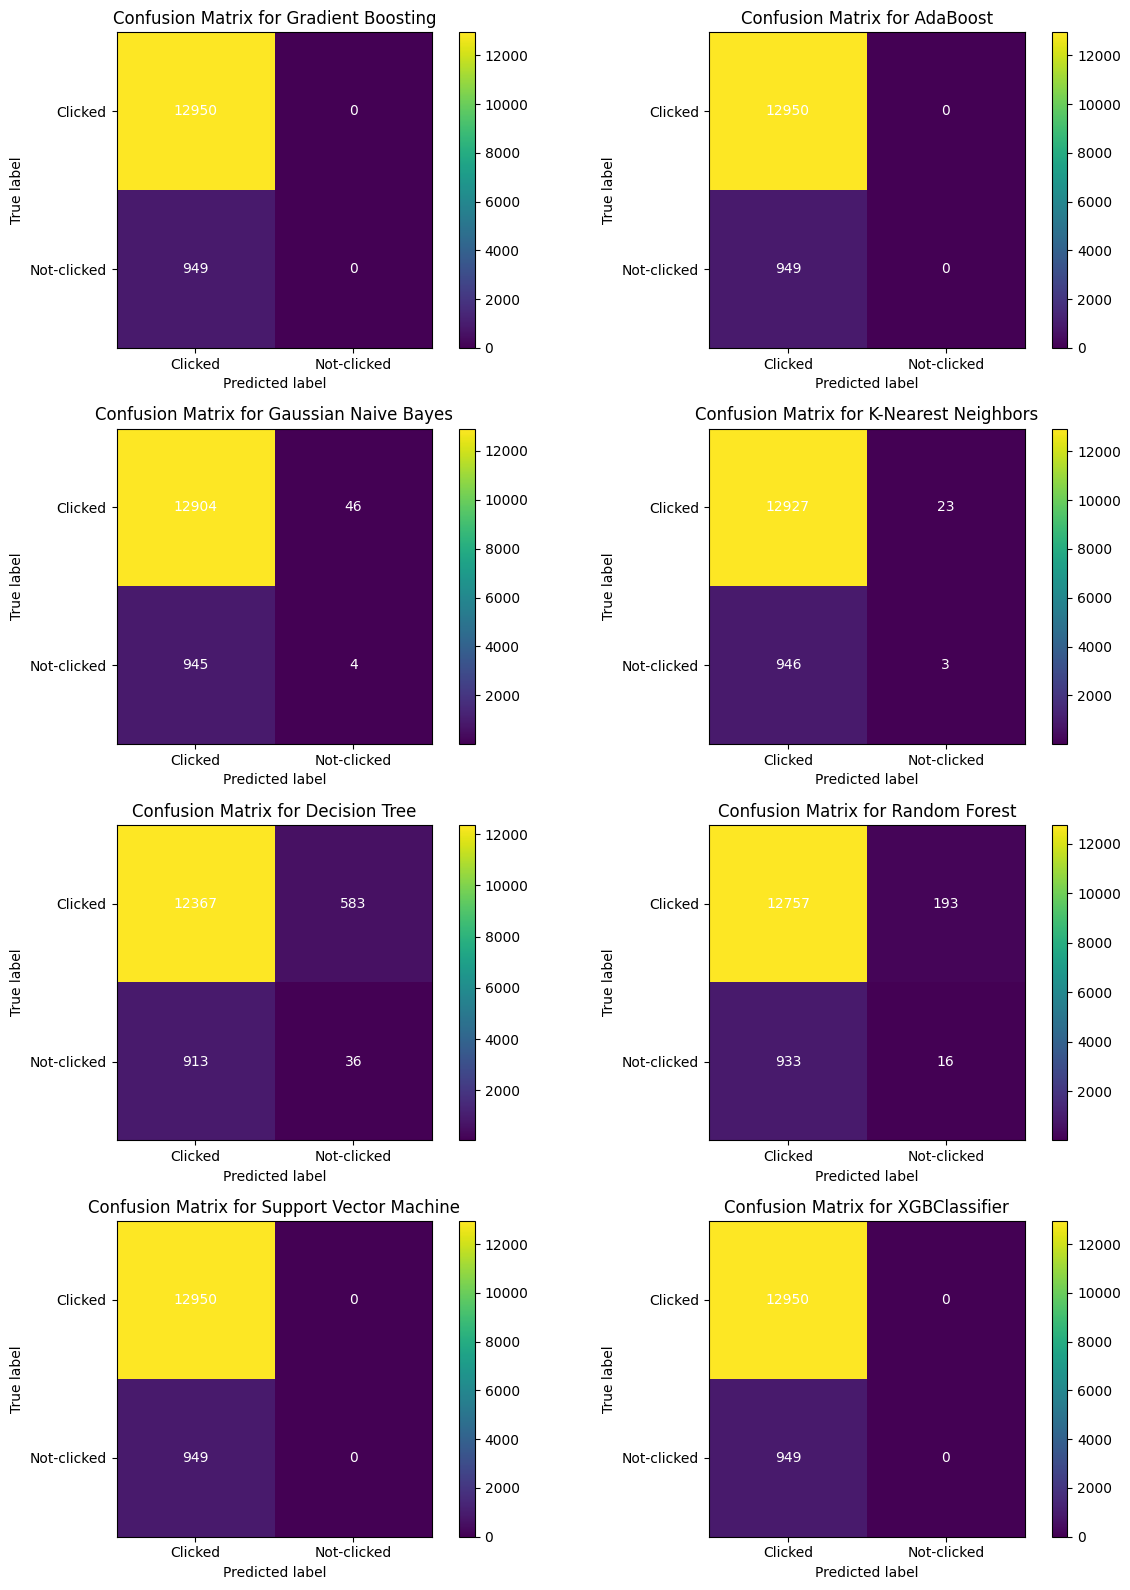

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Labels for confusion matrix
labels = ['Clicked', 'Not-clicked']

# Loop through each model and plot
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))  # Adjust grid size
axes = axes.flatten()

for i, entry in enumerate(cm_data):
    cm = entry['Matrix']
    model_name = entry['Model']
    plot_confusion_matrix(cm, labels, model_name, axes[i])

plt.tight_layout()
plt.show()



```
                   Model  Accuracy  Precision  Recall  F1 Score
4     K-Nearest Neighbors    0.8931     0.0728  0.0496    0.0590
1       Gradient Boosting    0.7700     0.0892  0.2605    0.1328
6           Random Forest    0.6956     0.0834  0.3507    0.1348
5           Decision Tree    0.6947     0.0830  0.3496    0.1341
3    Gaussian Naive Bayes    0.6097     0.0814  0.4641    0.1385
7  Support Vector Machine    0.5979     0.0689  0.3953    0.1173
2                AdaBoost    0.5553     0.0748  0.4902    0.1297
0     Logistic Regression    0.5397     0.0750  0.5127    0.1309
                  xGBoost    0.7666     0.0915  0.2745    0.1372 ```
```



#### I am here now


Best parameters from the RandomizedSearchCV
```
  best_params = {
      'subsample': 1.0,
      'scale_pos_weight': 13.78639006041263,
      'reg_lambda': 10,
      'reg_alpha': 1,
      'n_estimators': 1000,
      'min_child_weight': 3,
      'max_depth': 7,
      'learning_rate': 0.05,
      'gamma': 0.2,
      'colsample_bytree': 0.8
  }
```



In [87]:

#xGBoost parameter tuning
# Parameter grid for tuning
param_grid = {
  'n_estimators': [100, 300, 500],
  'learning_rate': [0.05, 0.1, 0.3],
  'max_depth': [3, 5, 7],
  'subsample': [0.8, 1.0],
  'colsample_bytree': [0.8, 1.0],
  'min_child_weight': [1, 3, 5],
  'scale_pos_weight': [],

  'gamma': [0, 0.1, 0.2],          # Minimum loss reduction for split
  'reg_alpha': [0, 0.1, 1],        # L1 regularization
  'reg_lambda': [1, 5, 10]         # L2 regularization
}


def run_param_tuning_model(df):
  # Base XGBClassifier
  xgb = XGBClassifier( eval_metric='auc',n_jobs=-1)
  #X,y
  y = df['is_click']
  X = df.drop('is_click',axis=1)

  #split
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=99,stratify=y)

  #optimization don't apply SMOTE

  # Apply SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes in the training set
  #smote = SMOTE(random_state=42)
  #X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

  X_train_resampled = X_train
  y_train_resampled = y_train


  # Compute imbalance ratio
  neg_count = (y_train_resampled == 0).sum()
  pos_count = (y_train_resampled == 1).sum()
  scale_pos_weight = neg_count / pos_count
  param_grid['scale_pos_weight'].append(scale_pos_weight)


  # GridSearchCV setup
  grid_search = GridSearchCV(
      estimator=xgb,
      param_grid=param_grid,
      scoring='roc_auc',  # AUC is best for CTR
      cv=3,               # 3-fold cross-validation
      verbose=1,
      n_jobs=-1           # Use all cores
      )

  # Fit the grid search
  grid_search.fit(X_train_resampled, y_train_resampled)

  # Best parameters
  print("Best Parameters:", grid_search.best_params_)

  # Evaluate on test set
  best_model = grid_search.best_estimator_
  y_pred_prob = best_model.predict_proba(X_test)[:, 1]
  print("Test ROC AUC:", roc_auc_score(y_test, y_pred_prob))

'''
def run_randmized_search_tuning_model(df):

  print(f"Entering run_randmized_search_tuning_model")
  # Base XGBClassifier
  xgb = XGBClassifier( eval_metric='auc',tree_method='gpu_hist',predictor='gpu_predictor')
  #X,y
  y = df['is_click']
  X = df.drop('is_click',axis=1)

  #split
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=99,stratify=y)

  #optimization dont apply SMOTE
  # Apply SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes in the training set
  #smote = SMOTE(random_state=42)
  #X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
  X_train_resampled = X_train
  y_train_resampled = y_train


  # Compute imbalance ratio
  neg_count = (y_train_resampled == 0).sum()
  pos_count = (y_train_resampled == 1).sum()
  scale_pos_weight = neg_count / pos_count


  # Base XGBClassifier
  xgb = XGBClassifier(eval_metric='auc')

  # Parameter distributions (can use lists or scipy.stats distributions)
  param_distributions = {
      'n_estimators': [100, 300, 500],
      'learning_rate': [0.05, 0.1, 0.3],
      'max_depth': [3, 5, 7],
      'subsample': [0.8, 1.0],
      'colsample_bytree': [0.8, 1.0],
      'min_child_weight': [1, 3, 5],
      'scale_pos_weight': [scale_pos_weight],  # computed earlier
      'gamma': [0, 0.1, 0.2],
      'reg_alpha': [0, 0.1, 1],
      'reg_lambda': [1, 5, 10]
  }

  # RandomizedSearchCV setup
  random_search = RandomizedSearchCV(
      estimator=xgb,
      param_distributions=param_distributions,
      n_iter=50,            # Number of random combinations to try
      scoring='roc_auc',
      cv=3,
      verbose=1,
      n_jobs=-1,
      random_state=42
  )

  # Fit the random search
  random_search.fit(X_train_resampled, y_train_resampled)

  # Best parameters
  print("Best Parameters:", random_search.best_params_)

  # Evaluate on test set
  best_model = random_search.best_estimator_
  y_pred_prob = best_model.predict_proba(X_test)[:, 1]
  print("Test ROC AUC:", roc_auc_score(y_test, y_pred_prob))

  # File name
  file_name = "output_log.txt"

  # Open file in append mode
  with open(file_name, "a") as f:
      # Write timestamp at the beginning
      f.write("Best Parameters: {random_search.best_params_}\n")
      f.write("\n Test ROC AUC: {roc_auc_score(y_test, y_pred_prob)}\n")
'''

def create_final_model(df):
  print("Creating the Final Model")
  # Best parameters from RandomizedSearchCV
  best_params = {
      'subsample': 1.0,
      'scale_pos_weight': 13.78639006041263,
      'reg_lambda': 10,
      'reg_alpha': 1,
      'n_estimators': 1000,
      'min_child_weight': 3,
      'max_depth': 7,
      'learning_rate': 0.05,
      'gamma': 0.2,
      'colsample_bytree': 0.8
  }

  X = df.drop('is_click', axis=1)  # Features
  y = df['is_click']               # Target

  X_train, X_test, y_train, y_test = train_test_split(
      X, y,
      test_size=0.3,        # 30% for testing
      random_state=99,      # For reproducibility
      stratify=y            # Keeps class distribution same in train and test
  )


  # Create final model
  final_model = XGBClassifier(**best_params, eval_metric='auc',
    #tree_method='gpu_hist',   # Enable GPU for training
    #predictor='gpu_predictor' # Enable GPU for inference
    tree_method='hist',   # Enable CPU for training
    n_jobs = -1   #use all the vailable CPUs
  )

  # Train on full training data
  final_model.fit(X_train, y_train)

  #Eveluate the model
  y_pred_prob = final_model.predict_proba(X_test)[:, 1]
  roc_auc = roc_auc_score(y_test, y_pred_prob)
  print(f"Test ROC AUC: {roc_auc:.4f}")


  y_pred = final_model.predict(X_test)
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("Recall:", recall_score(y_test, y_pred))
  print("F1 score", f1_score(y_test,y_pred))

  #increasee the precision threshold
  threshold = 0.7
  y_pred_custom = (y_pred_prob >= threshold).astype(int)
  print("Precision:", precision_score(y_test, y_pred_custom))

  #Save model for later use
  joblib.dump(final_model, "xgb_ctr_model.pkl")
  print("Model saved as xgb_ctr_model.pkl")

def catboost_model(df):

  print("Entering catboost_model")

  # -------------------------------
  # 2. Train-Test Split
  # -------------------------------
  X = df.drop('is_click', axis=1)
  y = df['is_click']

  X_train, X_test, y_train, y_test = train_test_split(
      X, y,
      test_size=0.3,
      random_state=42,
      stratify=y
  )

  # -------------------------------
  # 3. Identify Categorical Columns
  # -------------------------------
  categorical_cols = list(range(X.shape[1])) #All columns are categorical columns


  # Convert categorical columns to string in both train and test sets
  for col in X_train.columns:
    X_train[col] = X_train[col].astype(int)
    X_test[col] = X_test[col].astype(int)

  # -------------------------------
  # 4. Create CatBoost Pools
  # -------------------------------
  train_pool = Pool(X_train, y_train, cat_features=categorical_cols)
  test_pool = Pool(X_test, y_test, cat_features=categorical_cols)

  # -------------------------------
  # 5. Train CatBoost Model
  # -------------------------------

  neg_count = (y_train == 0).sum()
  pos_count = (y_train == 1).sum()
  class_weights = [1.0, neg_count / pos_count]

  model = CatBoostClassifier(
      iterations=500,
      learning_rate=0.05,
      depth=8,
      eval_metric='AUC',
      random_seed=42,
      verbose=10,
      #class_weights=class_weights, #handle class imbalance
      auto_class_weights='Balanced'
  )

  model.fit(train_pool, eval_set=test_pool)

  # -------------------------------
  # 6. Evaluate Model
  # -------------------------------
  y_pred_prob = model.predict_proba(X_test)[:, 1]
  roc_auc = roc_auc_score(y_test, y_pred_prob)
  print(f"Test ROC AUC: {roc_auc:.4f}")

  # -------------------------------
  # 7. Save Model
  # -------------------------------
  model.save_model("catboost_ctr_model.cbm")
  print("Model saved as catboost_ctr_model.cbm")

  # -------------------------------
  # 8. Load Model Later
  # -------------------------------
  loaded_model = CatBoostClassifier()
  loaded_model.load_model("catboost_ctr_model.cbm")


In [95]:
def main(str):
  import sys
  print(str)

  df_train = read_data()
  df_train = data_creation(df_train)
  df_train = col_encoding(df_train)

  sample_df = df_train.sample(frac=1,random_state=99)
  print(f"commented CVSearch model\n")
  #run_param_tuning_model(sample_df)

  print(f"commented randomizedSearchCV model\n")
  #run_randmized_search_tuning_model(sample_df)

  #print feature impo
  #feature_imp(df_train)

  #dropping user_id and user_id_ctrl
  df_train.drop(columns=['user_id','userid_ctr'],inplace=True)

  #print feature impo
  print("******* Feature importance after dropping user_id and userid_ctr")
  feature_imp_without_user_id(df_train)

  #print(f"Exiting after creating the xgboost")
  #sys.exit(0)

  # catboost_model(sample_df)

  print("****************************************************\n")
  print("Final df before model creation")
  print(df_train.info())
  print("****************************************************\n")

  print(f"commenting stacked_model")
  #stacked_model(df_train)

  start_time = datetime.now()

  print(f"running xgBoost Model creation")
  create_final_model(sample_df)

  end_time = datetime.now()
  print(f"total runtime = {end_time - start_time}")

#if __name__ == "__main__":
#  main("AI & ML Developer")

Please run
commented CVSearch model

commented randomizedSearchCV model

******* Feature importance after dropping user_id and userid_ctr


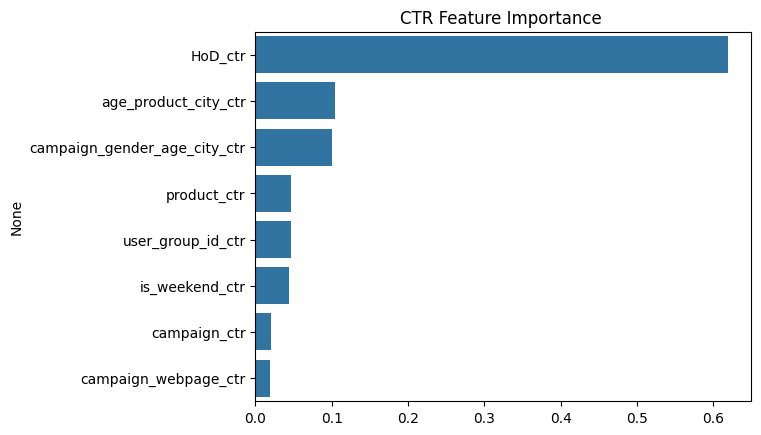

****************************************************

Final df before model creation
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463291 entries, 0 to 463290
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   product                       463291 non-null  int64  
 1   campaign_id                   463291 non-null  int64  
 2   webpage_id                    463291 non-null  int64  
 3   product_category_1            463291 non-null  int64  
 4   user_group_id                 463291 non-null  int64  
 5   gender                        463291 non-null  int64  
 6   age_level                     463291 non-null  float64
 7   user_depth                    463291 non-null  float64
 8   city_development_index        463291 non-null  float64
 9   var_1                         463291 non-null  int64  
 10  is_click                      463291 non-null  int64  
 11  HoD                

In [96]:
main("Please run")

### Conclusion : Final Model xGBoost


```
xgBoost Model creation Final Model
Test ROC AUC: 0.9444
Accuracy: 0.8492747575330244
Recall: 0.8870092563038621
F1 score 0.44318634877601465
Precision: 0.390641517832304
Model saved as xgb_ctr_model.pkl
total runtime = 0:00:49.498268
```



** 2 Feature Importance Plot **
Purpose: Identify most influential features Type: Horizontal bar chart Shows: Top 20 features
for tree-based models Insights: Which features drive clicks?
**Ans**:
**3 most influential features driving the Clicks:**
** HoD_ctr                         0.618716
**age_product_city_ctr            0.104534
**campaign_gender_age_city_ctr    0.100165

In [91]:
def stacked_model(df):
  from catboost import CatBoostClassifier
  from lightgbm import LGBMClassifier
  from sklearn.linear_model import LogisticRegression
  from sklearn.ensemble import StackingClassifier
  from sklearn.model_selection import train_test_split
  from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

  # -------------------------------
  # 1. Train-Test Split
  # -------------------------------
  X = df.drop('is_click', axis=1)
  y = df['is_click']

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.3, random_state=42, stratify=y
  )

  # -------------------------------
  # 2. Define Base Models
  # -------------------------------
  neg_count = (y_train == 0).sum()
  pos_count = (y_train == 1).sum()
  class_weights = [1.0, neg_count / pos_count]

  catboost_model = CatBoostClassifier(
      iterations=500,
      learning_rate=0.05,
      depth=8,
      eval_metric='AUC',
      random_seed=42,
      verbose=10,
      class_weights=class_weights, #handle class imbalance
      #auto_class_weights='Balanced'
      )


    # Best parameters from RandomizedSearchCV
  best_params = {
      'subsample': 1.0,
      'scale_pos_weight': 13.78639006041263,
      'reg_lambda': 10,
      'reg_alpha': 1,
      'n_estimators': 1000,
      'min_child_weight': 3,
      'max_depth': 7,
      'learning_rate': 0.05,
      'gamma': 0.2,
      'colsample_bytree': 0.8
  }



  xgb_model = XGBClassifier(**best_params, eval_metric='auc',
    #tree_method='gpu_hist',   # Enable GPU for training
    #predictor='gpu_predictor' # Enable GPU for inference
    tree_method='hist',   # Enable CPU for training
    n_jobs = -1   #use all the vailable CPUs
  )

  lightgbm_model = LGBMClassifier(
      n_estimators=300, learning_rate=0.05, max_depth=7
  )

  # -------------------------------
  # 3. Define Meta-Model (Logistic Regression)
  # -------------------------------
  meta_model = LogisticRegression(max_iter=1000)

  # -------------------------------
  # 4. Create Stacking Classifier
  # -------------------------------
  stacked_model = StackingClassifier(
      estimators=[
          ('catboost', catboost_model),
          ('lightgbm', lightgbm_model),
          ('xgb', lightgbm_model)
      ],
      final_estimator=meta_model,
      stack_method='predict_proba',  # Use probabilities for meta-model
      passthrough=True,              # Pass original features to meta-model
      n_jobs=-1
  )

  # -------------------------------
  # 5. Train Stacked Model
  # -------------------------------
  stacked_model.fit(X_train, y_train)

  # -------------------------------
  # 6. Evaluate
  # -------------------------------
  y_pred_prob = stacked_model.predict_proba(X_test)[:, 1]
  y_pred = stacked_model.predict(X_test)

  roc_auc = roc_auc_score(y_test, y_pred_prob)
  print("ROC_AUC:",roc_auc)
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("Precision:", precision_score(y_test, y_pred))
  print("Recall:", recall_score(y_test, y_pred))





```
 17  campaign_webpage_ctr          463291 non-null  float64
 18  age_product_city_ctr          463291 non-null  float64
 19  campaign_gender_age_city_ctr  463291 non-null  float64
 20  userid_ctr                    463291 non-null  float64
 21  product_ctr                   463291 non-null  float64
 22  user_group_id_ctr             463291 non-null  float64
 23  campaign_ctr                  463291 non-null  float64
 24  HoD_ctr                       463291 non-null  float64
 25  is_weekend_ctr                463291 non-null  float64```



In [92]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

def feature_imp(df):
  # Example DataFrame
  # Assume df has columns: user_ctr, product_ctr, hour, day_of_week, clicked (target)
  X = df[['userid_ctr', 'product_ctr','user_group_id_ctr','campaign_ctr', 'HoD_ctr', 'is_weekend_ctr', 'campaign_webpage_ctr','age_product_city_ctr','campaign_gender_age_city_ctr']]

  y = df['is_click']

  # Split data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Random Forest for feature importance
  rf = RandomForestClassifier(n_estimators=100, random_state=42)
  rf.fit(X_train, y_train)

  # Feature importance
  importances = pd.Series(rf.feature_importances_, index=X.columns)
  print(importances.sort_values(ascending=False))


In [93]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt


def feature_imp_without_user_id(df):
  # Example DataFrame
  # Assume df has columns: user_ctr, product_ctr, hour, day_of_week, clicked (target)
  X = df[['product_ctr','user_group_id_ctr','campaign_ctr', 'HoD_ctr', 'is_weekend_ctr', 'campaign_webpage_ctr','age_product_city_ctr','campaign_gender_age_city_ctr']]

  y = df['is_click']

  # Split data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Random Forest for feature importance
  rf = RandomForestClassifier(n_estimators=100, random_state=42)
  rf.fit(X_train, y_train)

  # Feature importance
  importances = pd.Series(rf.feature_importances_, index=X.columns)
  importances_sorted = importances.sort_values(ascending=False)
  sns.barplot(x=importances_sorted.values, y=importances_sorted.index)
  plt.title("CTR Feature Importance ")
  plt.show()


  #print(importances.sort_values(ascending=False))


**Sample Size 0.5**

```
Entering run_randmized_search_tuning_model
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.8, 'scale_pos_weight': np.float64(13.732132041187159), 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}
Test ROC AUC: 0.5759689005660811
total runtime = 0:07:09.732878
```

